# <center>Telstra Fault Severity Classification</center>
<center>Dwipam Katariya, IU Data Science</center>
<center>Reduced Log-Loss from 1.2 to 0.54</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as sct
import pylab
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Contents:


###     <a href='#EDA'>1. Exploratory Data Analysis:</a>
         1.1 Univariate Data Analysis - Exploring univariate variables (Location, Event type, Log Feature, Volume,
         resource type and severity type)
         1.2 Bivariate Analysis - Relation between Volume and Fault Severity.
###     <a href='#FE'>2. Feature Engineering:</a>
         2.1 Transformation for continuous feature - Took 1/log2(scaled**2) feature to normalize and analyse the
         normality.
         2.2 Transformation for Categorical feature - Perform one-hot encoding for categorical features of event 
         type, resource type and severity type after binning variables into 3 categories.
         2.3 Transforming categorical for continuous features - Transform log feature category such that each id has
         total volume for the respective category. "sum over ((one-hot encoding)*volume) group by id".
         2.4 Outlier treatment for Volume - Cap outliers <1.5*IQR> after the transformation done at step 2.3.
###     <a href='#MO'>3. Modeling:</a>
         As Telstra says that every event is time dependent and represented by id. I considered id in modeling.
         3.1 Logistic regression: As linear models are easy to explain and has pretty good generalization 
         capability, it's always a good idea to try Logistic regression.
         3.2 Gradient Boosting Machine: Increase variance due to high bias in logistic regression to control 
         Bias - Variance trade-off.
         3.3 Random Forest: Reduce variance but captures non-linearity in the data.
###      <a href='#CO'>4. Conclusion</a>
###      <a href='#FU'>5. Future Work</a>

<a id = 'EDA'></a>
## Exploratory Data Analysis:

In [24]:
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test.csv',index_col=0)
event_type = pd.read_csv('event_type.csv',index_col=0)
log_feature = pd.read_csv('log_feature.csv',index_col=0)
resource_type = pd.read_csv('resource_type.csv',index_col=0)
severity_type = pd.read_csv('severity_type.csv',index_col=0)
train_index = train.index

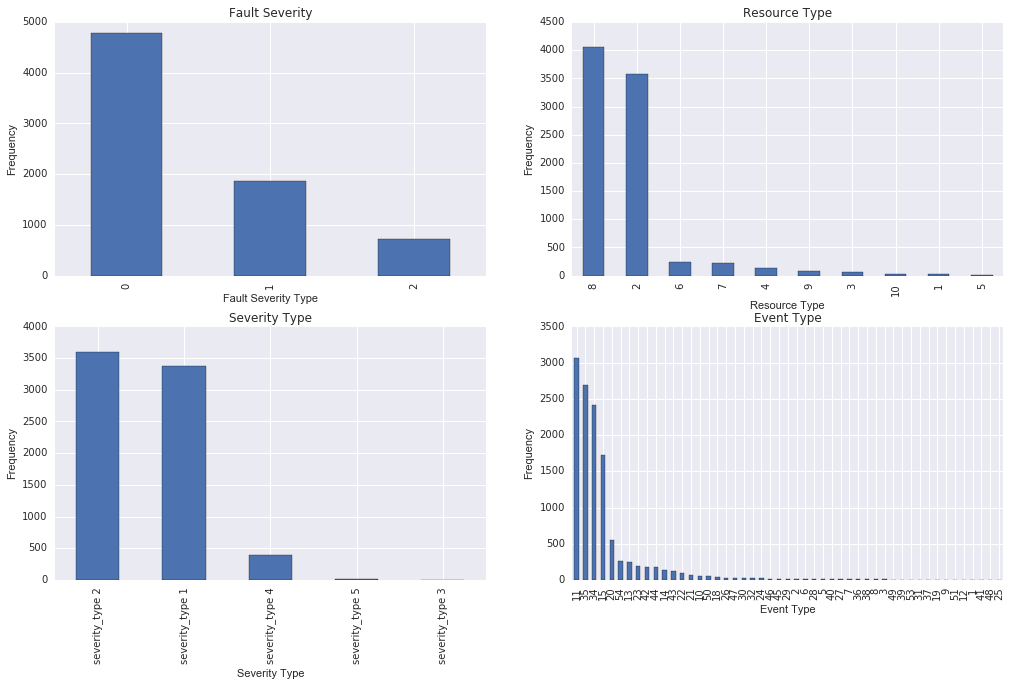

In [32]:
fig, ax = plt.subplots(nrows = 2,ncols = 2)
fa = train['fault_severity'].value_counts().plot(kind = 'bar',ax=ax[0,0],title="Fault Severity", y = "Frequency")
resourceType = resource_type.loc[resource_type.index.isin(train.index)]
severityType = severity_type.loc[severity_type.index.isin(train.index)]
eventType = event_type.loc[event_type.index.isin(train.index)]
re = resourceType.resource_type.map(lambda x:x.split(' ')[1]).value_counts().plot(kind='bar',ax = ax[0,1],
                                                              title = "Resource Type", y = "Frequency")
fa.set_xlabel("Fault Severity Type"); fa.set_ylabel("Frequency")
re.set_xlabel("Resource Type"); re.set_ylabel("Frequency")

se = severityType.severity_type.value_counts().plot(kind = 'bar',ax = ax[1,0],title = "Severity Type",figsize = [17,10])
se.set_xlabel("Severity Type"); se.set_ylabel("Frequency")

ev = eventType.event_type.map(lambda x:x.split(' ')[1]).value_counts().plot(kind = 'bar',ax = ax[1,1],title = 'Event Type')
ev.set_xlabel("Event Type");ev.set_ylabel("Frequency")

- It's obvious from Fault severity that samples with no faults are extremely high that one with faults. Frequency also decreases as fault severity increases.
- Resource type 8 has the highest frequency distribution followed by resource type 2.
- Severity type 2 and Severity type 1 has extremely large distribution than other. We can consider binning these variables to decreases the skewness.
- Other than Event Type 11,35,34,15 other event types has fairly low frequency distribution and we can bin them into different categories. 11,35 -High 34,15, 20 - Medium and others in Low.  

<a id = 'FE'></a>
## Feature Engineering

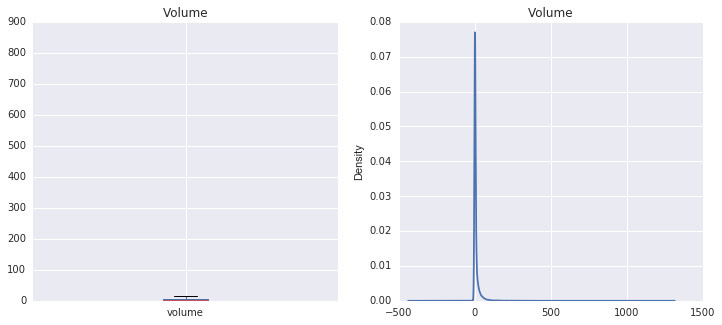

In [26]:
fig,ax = plt.subplots(nrows = 1, ncols = 2)
log_feature.volume.loc[log_feature.index.isin(train.index)].plot(kind = 'box',figsize = [12.0,5.0],title="Volume",ax = ax[0])
log_feature.volume.loc[log_feature.index.isin(train.index)].plot(kind = 'density',figsize = [12.0,5.0],title="Volume",ax = ax[1])
#log_feature_train = log_feature.loc[log_feature.id.isin(train.id)].query('volume<500')

Volume is heavily right skewed and hence we can transform the variable to reduce skewness.

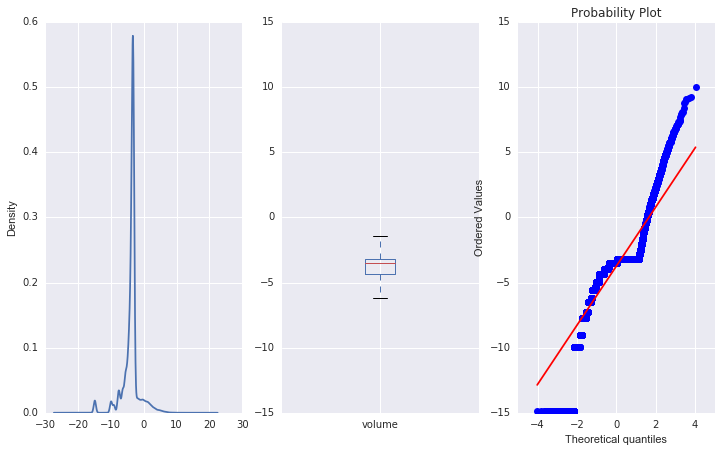

In [27]:
matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)
log_feature_train = log_feature.loc[log_feature.index.isin(train.index)]
log_feature_train.volume = (((np.log2(((log_feature_train.volume - np.mean(log_feature_train.volume))/np.std(log_feature_train.volume))**2))))
fig,ax = plt.subplots(nrows = 1,ncols= 3)
sct.probplot(log_feature_train.volume,dist="norm", plot=plt)
log_feature_train.volume.plot(kind='density', ax = ax[0])
log_feature_train.volume.plot(kind='box', ax = ax[1])
plt.show()

We have taken log2(square(normalized(x)) to reduce the heavily right skewness in volume as this would have affected our modelling. Looking at boxplot, density plot and qq-plot, it seems the data is still skewed, but skewness is reduced to large extend. 
It will be interesting to know how different are volumes for a all the three categories of fault severity.


Standard Deviation fault severity wise


,volume
fault_severity,
0,2.620031
1,1.825666
2,3.463557


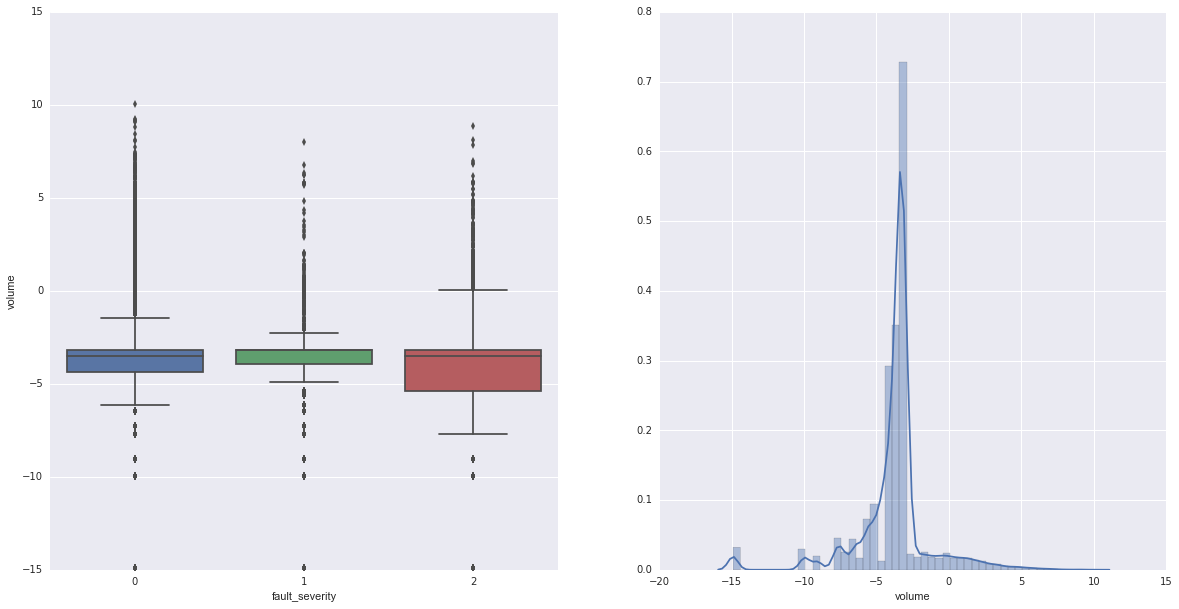

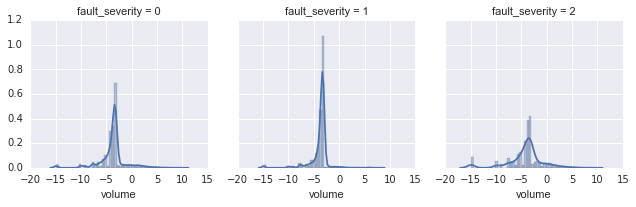

In [6]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

x = train.join(log_feature_train)[['volume','fault_severity']]
fig,ax = plt.subplots(nrows = 1, ncols = 2)
sns.boxplot(x = 'fault_severity', y = 'volume',data = x,ax = ax[0])
g = sns.FacetGrid(x,col='fault_severity')
g.map(sns.distplot,"volume")
sns.distplot(x['volume'],ax = ax[1])
print "Standard Deviation fault severity wise"
pd.DataFrame(x.groupby('fault_severity')['volume'].std())


It's interesting to know that for Low fault severity there is high concentration of values with lower spread, however for High severity distribution has a larger spread. Volume variables seems to have big impact on fault severity. Lets cap outliers from our main dataset that are visual for initial model building. Later we can improve and remove outliers relative to fault severity.

In [7]:
idxs = log_feature_train.loc[(log_feature_train.volume>-7) & (log_feature_train.volume<2)].index
mx = max(log_feature.iloc[idxs].volume)
mn = min(log_feature.iloc[idxs].volume)
def cap(x):
    if x>mx: x = mx
    if x<mn: x = mn
    return x
log_feature.volume = map(lambda x:cap(x),log_feature.volume)
log_feature.volume = (((np.log2(((log_feature.volume - np.mean(log_feature.volume))/np.std(log_feature.volume))**2))))

We can try other and include interaction with feature type. As every id has number of feature types and its associated volume, we can multiply them with their respective volume and add the values together for each id. So that it captures impact of volume for a feature type. We can also add the occurrences of log features for a particular id and check if there is correlation for fault_severity.

In [8]:
temp = log_feature
log_feature = pd.get_dummies(log_feature);
log_feature.iloc[:,1:] = log_feature.iloc[:, 1:].multiply(log_feature['volume'], axis="index").groupby(log_feature.index).sum()
log_feature['Count_Log'] = temp.groupby(temp.index).size()


Now let's convert resource types and event types to one-hot encoding such that every unique id will have number of resources for that accounted for a resource type. So if id has 3 rows for a particular resource type there will be integer value 3 for the that resource type and rest all will be 0 as nothing accounted for those resource type.


In [9]:
def eventTrans(x):
    if x in (11, 35): x = 'High'
    elif x in (34, 15, 20): x = 'Medium'
    else: x = 'low'
    return x
event_type = pd.get_dummies(event_type.event_type.map(lambda x:eventTrans(int(x.split(' ')[1].strip()))))

In [10]:
event_type = event_type.groupby(event_type.index).sum()

In [11]:
def resourceTrans(x):
    if x in (1,2): x = 'HighR'
    else: x = 'LowR'
    return x
resource_type = pd.get_dummies(resource_type.resource_type.map(lambda x:resourceTrans(int(x.split(' ')[1].strip()))))

In [12]:
resource_type = resource_type.groupby(resource_type.index).sum()

In [13]:
def trans(X):
    x = resource_type.join(event_type).join(log_feature)
    x = x.groupby(x.index).mean()
    return X.join(x)
train = trans(train)
train['id'] = train_index
test = trans(test)
test['id'] = test.index


In [14]:
train.corr().abs().unstack().sort_values(ascending = False)[:10]

log_feature_feature 113  log_feature_feature 26     1.0
log_feature_feature 26   log_feature_feature 113    1.0
log_feature_feature 366  log_feature_feature 364    1.0
log_feature_feature 364  log_feature_feature 366    1.0
id                       id                         1.0
log_feature_feature 338  log_feature_feature 338    1.0
log_feature_feature 346  log_feature_feature 90     1.0
                         log_feature_feature 89     1.0
                         log_feature_feature 88     1.0
                         log_feature_feature 346    1.0
dtype: float64

Due to dummy trap we have perfect multicollinearity in our model. However, this won't affect predictive power of the base learner, though coefficients won't be interpretable due to multi-collinearity. But first we can check for important variables, from base learner, and stage 2 learner.

<a id = 'MO'></a>
## Modeling

### Logistic Regression

As the data is sparse, with mixed type of variables with high multicollinearity, we can fit the base model with Logistic regression to learn if data is linearly classifiable. Then we can fit Gradient Boosting Machine and later to tune up the parameters with Grid Search. 

In [15]:
import graphlab as gl
def logistic(train,test):
    model = gl.logistic_classifier.create(train,target = 'fault_severity',max_iterations = 100,verbose=False)
    model.evaluate(train)
    return (model,model.predict_topk(gl.SFrame(test),output_type='probability'))
model,predictions = logistic(gl.SFrame(train),gl.SFrame(test))

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1488079500.log


This non-commercial license of GraphLab Create for academic use is assigned to ddkatari@iu.edu and will expire on February 26, 2018.


1.2 log loss is pretty huge, and it seems that data is not linearly classifiable.  When we assess these results on test data it seems to have low log loss than one on train data, hence logistic regression underfits the data. It would be good idea to apply GBM as it increases Variance as we increase number of learners. Also ensemble learning algorithms like GBM, RF, ADABoost caputres the non-linearity in the data due to randomization and fitting models based on error made in the previous models(except RF). 

### Gradient Boosting Machine

In [16]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.transforms.decomposition import H2OPCA
h2o.init()
from h2o.grid.grid_search import H2OGridSearch as gs
def grid_search(X_train,test,hyperParam,grid):
    X_train = h2o.H2OFrame(X_train);X_train['fault_severity'] = (X_train['fault_severity']).asfactor()
    if grid == 'grid':
        model = gs(H2OGradientBoostingEstimator(distribution="multinomial"),\
                   hyper_params = hyperParam,grid_id = "grid1")
        model.train(x = range(1,X_train.ncol-1),y = 0,training_frame=X_train,nfolds=10)
        return model,pd.DataFrame(h2o.as_list(model)).sort('logloss')
        
    else:
        model = H2OGradientBoostingEstimator(distribution = 'multinomial', ntrees = hyperParam['ntrees']\
                                              , max_depth = hyperParam['max_depth'], learn_rate = hyperParam['learn_rate']\
                                              ,nfolds = 10)
        model.train(y = "fault_severity",training_frame=X_train)
    score = model.predict(h2o.H2OFrame(test))
    output(h2o.as_list(score))
    return (model,score)

def output(score):
    score.columns = ['id','predict_0','predict_1','predict_2']
    score['id'] = test.index
    score = score.groupby(score.index).mean()
    score.to_csv(path_or_buf = 'scored.csv',index = False,sep=',')




Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,19 hours 9 mins
H2O cluster version:,3.10.0.8
H2O cluster version age:,4 months and 15 days !!!
H2O cluster name:,H2O_from_python_dwipam_vw5hb3
H2O cluster total nodes:,1
H2O cluster free memory:,239.4 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [17]:
#hyperParam = {'ntrees' : [10,100,150,300,500],'max_depth' : [2,10,50], 'learn_rate' : [0.02,0.1,0.2,0.7]}
hyperParam = {'ntrees' : 100,'max_depth' : 10, 'learn_rate' : 0.1}
modelgbm,scoregbm = grid_search(train,test,hyperParam,'seq')

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████████████████████████| 100%


First, I tried with the sequential search with few parameters and maintaining the stubs for trees that might work and then applied Grid search to further tune the parameters. Base learner for sequential search gave me Test Log loss of 1.1 on the test data, while grid search gave me 0.58. For GBM it seems that as we increase depth and number of trees, variance also increases, that means Overfitting happens. There is as low as log-loss(0.04) on train while high log_loss(0.58) on validation. We can fit RF as it reduces variance and slightly increases bias, due to random sampling with replacement. It also captures non-linearity and we could overcome Logistic regression problem of underfitting, as well as GBM problem of over-fitting.

### Distributed Random Forest Classifier

In [18]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
def random_forest(X_train, test, hyperParam,grid):
    X_train = h2o.H2OFrame(X_train);X_train['fault_severity'] = (X_train['fault_severity']).asfactor()
    if grid =='grid':
        return 0
    else:
        model = H2ORandomForestEstimator(model_id = 'base_rf',ntrees = hyperParam['ntree'], max_depth = hyperParam['max_depth'])
        model.train(y="fault_severity",training_frame = X_train)
        score = model.predict(h2o.H2OFrame(test))
        output(h2o.as_list(score))
        return (model,score)
hyperParam = {'ntree':1300,'max_depth':100}
modeldrf,scoredrf = random_forest(train,test,hyperParam,'seq')

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████████████████████████| 100%


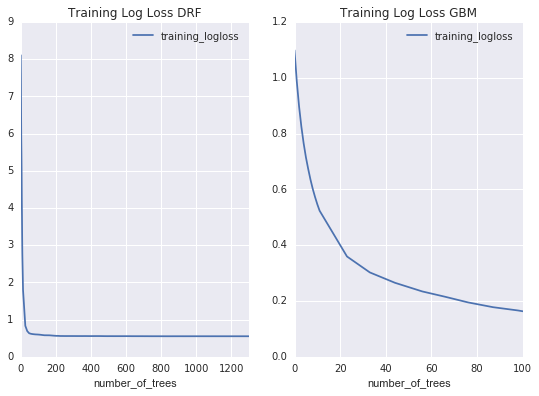

In [33]:
fig,ax = plt.subplots(nrows = 1, ncols = 2)
modeldrf.scoring_history().plot(y='training_logloss',x='number_of_trees',figsize=[9,5],title = "Training Log Loss DRF",ax=ax[0])
modelgbm.scoring_history().plot(y='training_logloss',x='number_of_trees',figsize=[9,6], title = "Training Log Loss GBM",ax=ax[1])

Excellent! We got log loss of 0.56 and we were right about high variance when applied Gradient Boosting Machine.

### Combined model

As, GBM slightly over-fitted, however captures non-linearity better than RF, but RF gave us the model with low variance, averaging the probabilities should give us better approximation of test data.

In [20]:
scoredrf = h2o.as_list(scoredrf); scoredrf['id'] = test.index
scoregbm = h2o.as_list(scoregbm); scoregbm['id'] = test.index
score = scoredrf.append(scoregbm).groupby('id').mean()
output(score)

Awesome! We got log loss 0.54 

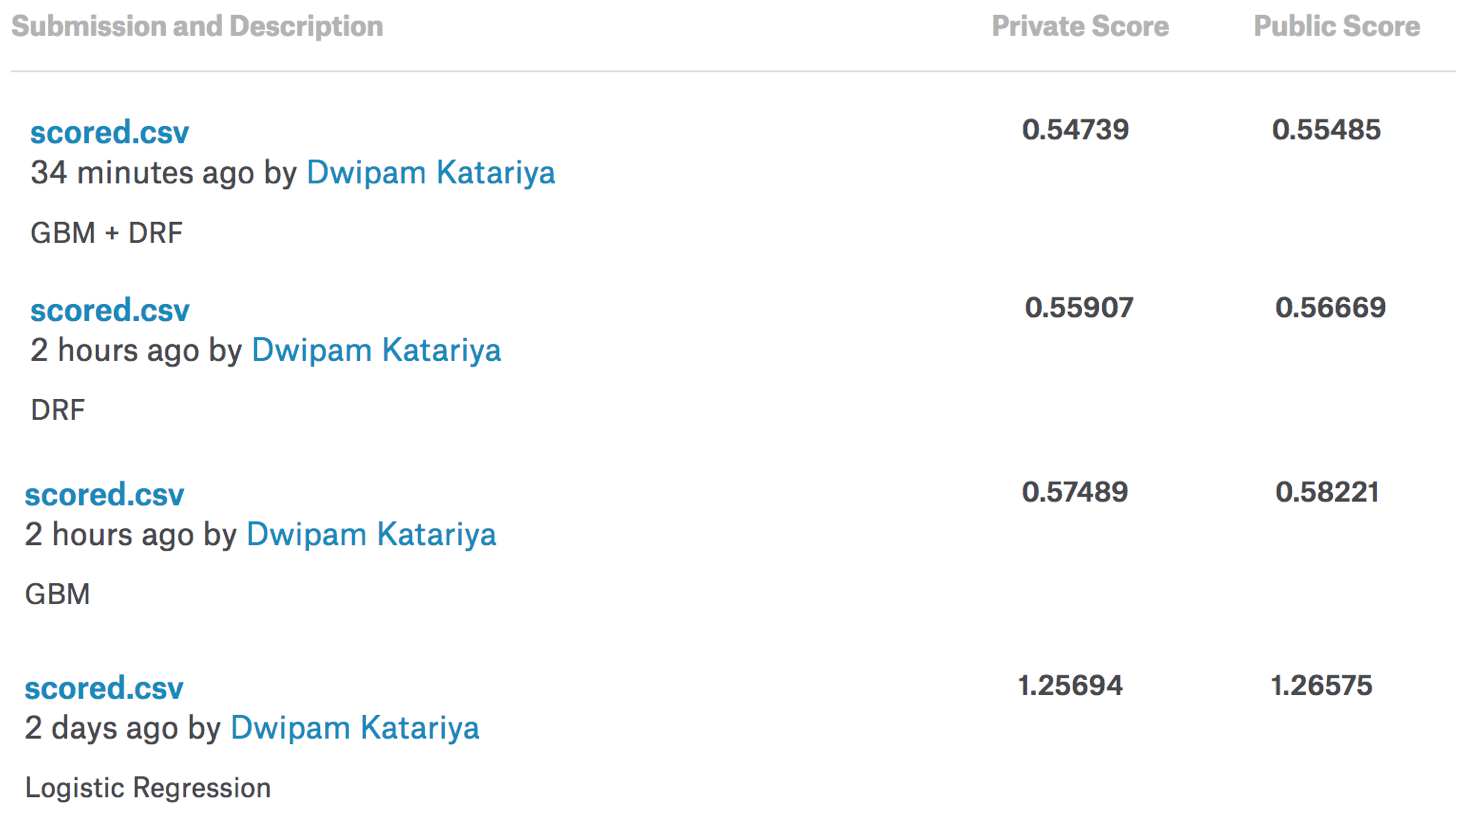

In [21]:
from IPython.display import Image
Image(filename='Telstra.png')

<a id = 'CO'></a>
## Conclusion:

- Most Important variables responsible for degree of fault severity is Location, Volume, id and number of times id recorded for log feature.
- Just normalizing Volume and transforming it drastically reduced log loss.
- Binning categorical features gave the better generalization and reduced complexity of model.
- Transformation done on Log_feature proved to have some significance.
- Other Feature engineering and Outlier treatment also accounted for some degree of reduction in Log Loss.
- Averaging results from GBM and Random Forest gave a better approximation of population data it seems.

<a id = 'FU'></a>
## Future Work:
 - Perform Neural Network modeling to get better approximations of non-linearity
 - Perform Dimensionality reduction to reduce multicollinearity.
 - Perform unsupervised learning to look if there are id's in the neighborhood of id's of train data.
 - Try different transformations on Volume and bin id's into different categories.
 - Work on tuning parameters of RF and GBM (GBM with Laplace Smoothing, RF with different bags, GBM with decay rate etc.)